In [2]:
import pandas as pd
import matplotlib.pyplot as plt

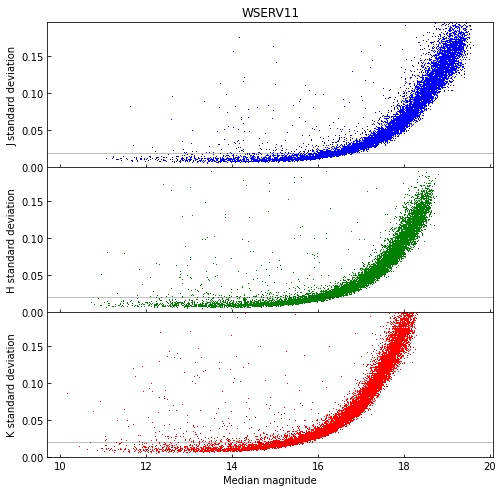

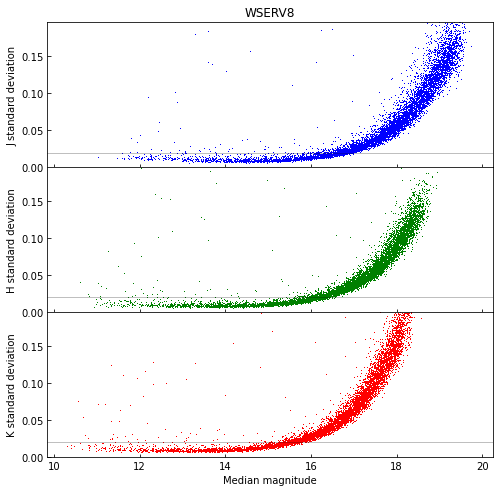

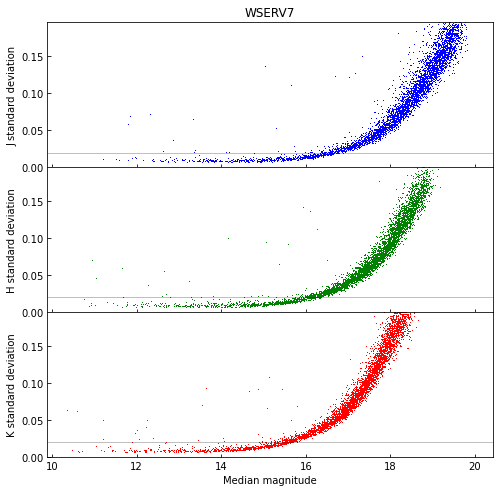

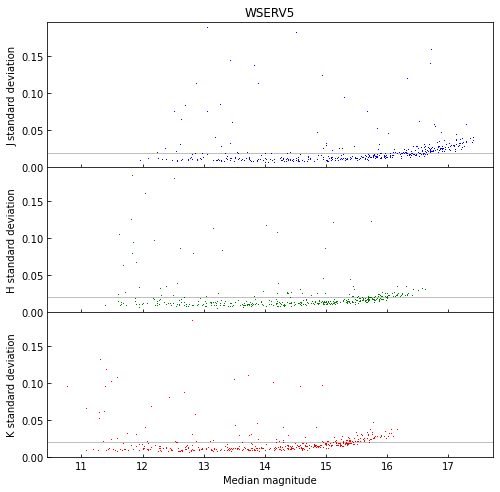

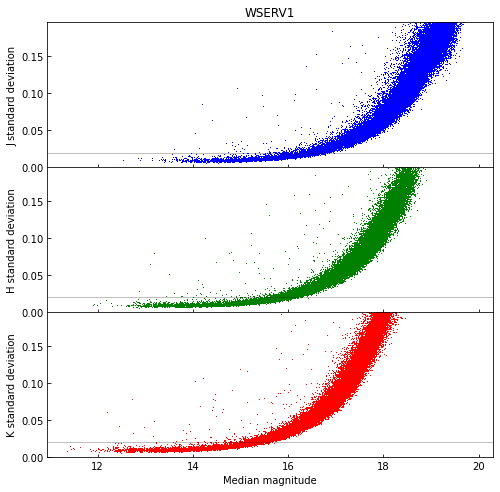

In [25]:
wserv_ids = [1, 5, 7, 8, 11]

output_root = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/Data/analysis_artifacts"

for wserv in wserv_ids[::-1]:

    output_path = os.path.join(
        output_root,
        f"wserv{str(wserv)}",
        f"WSERV{str(wserv)}_graded_clipped0.95_scrubbed0.1_dusted0.5_summary_spreadsheet.h5",
    )

    ds = pd.read_hdf(output_path, key='table')
    
    q2_all_indices = (
        (ds["count"]["N_J"] > 40)
        & (ds["count"]["N_J"] < 160)
        & (ds["count"]["N_H"] > 40)
        & (ds["count"]["N_H"] < 160)
        & (ds["count"]["N_K"] > 40)
        & (ds["count"]["N_K"] < 160)
        & (ds["max"]["JPPERRBITS"] == 0)
        & (ds["max"]["HPPERRBITS"] == 0)
        & (ds["max"]["KPPERRBITS"] == 0)
        & (ds["median"]["PSTAR"] > 0.75)
    )
    
    fig, axes = plt.subplots(3, sharex=True, figsize=(8,8))
    
    axes[0].plot(ds['median']['JAPERMAG3'][q2_all_indices], ds['std']['JAPERMAG3'][q2_all_indices], 'b,')
    axes[1].plot(ds['median']['HAPERMAG3'][q2_all_indices], ds['std']['HAPERMAG3'][q2_all_indices], 'g,')
    axes[2].plot(ds['median']['KAPERMAG3'][q2_all_indices], ds['std']['KAPERMAG3'][q2_all_indices], 'r,')

    for ax, band in zip(axes, ["J", "H", "K"]):
        ax.axhline(0.02, color='k', alpha=0.5, lw=0.5)
        ax.set_ylim(0, 0.195)

        ax.set_ylabel(f"{band} standard deviation")
        ax.tick_params(direction='in')
        
    axes[2].set_xlabel("Median magnitude")
    axes[0].set_title(f"WSERV{wserv}")
    plt.subplots_adjust(hspace=0)
    